In [195]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE, mean_absolute_error as MAE

import pickle

%matplotlib inline

In [196]:
df = pd.read_csv('../data/vehicles.csv')
outback = df[df.model.isin(['outback', 'legacy'])].copy()
del df
outback.drop(['Unnamed: 0', 'id', 'url', 'region_url', 'image_url', 'state', 'lat', 'long', 'posting_date', 'VIN', 'size', 'type', 'drive', 'region', 'manufacturer'], inplace=True, axis=1)
outback.rename({'price':'USD'}, axis=1, inplace=True)
outback.rename({'odometer':'miles'}, axis=1, inplace=True)

## Exploring columns

In [197]:
for column in outback.columns:
    print('=========================')
    print(column.upper())
    print('\n')
    print(outback[column].value_counts())
    print('=========================')
    print('\n\n')

## Removing outliers

In [198]:
from scipy import stats
outback = outback[(np.abs(stats.zscore(outback[['USD', 'year', 'miles']])) < 3).all(axis=1)]
outback = outback[outback.USD > 500]
outback = outback[outback.miles > 1000]

## Filling missing values

In [199]:
outback.isna().sum()/len(outback)*100

USD            NaN
year           NaN
model          NaN
condition      NaN
cylinders      NaN
fuel           NaN
miles          NaN
title_status   NaN
transmission   NaN
paint_color    NaN
description    NaN
dtype: float64

In [200]:
re_excellent = re.compile(r'.*(excellent condition).* | .*(condition. excellent).*')
re_good = re.compile(r'.*(good condition).* | .*(condition. good).*')
re_like_new = re.compile(r'.*(like new condition).* | .*(condition. like new).*')
re_fair = re.compile(r'.*(fair condition).* | .*(condition. fair).*')

re_4cyl = re.compile(r'.*(2.5).*')
re_6cyl = re.compile(r'.*(3.0).*')

In [201]:
# Drops two vehicles with extreme prices, and two vehicles with no information other than miles
try:
    outback.drop([416548, 239974, 440910,248095] , inplace=True)
    # Drop duplicates
    outback.drop_duplicates(subset='description', inplace=True)
except KeyError:
    pass

try:
    # Use Regex to fill condition values from the vehicle's description
    outback.condition.fillna(outback[outback.description.apply(lambda x: bool(re_fair.match(x.lower())))].condition.fillna('fair'), inplace=True)
    outback.condition.fillna(outback[outback.description.apply(lambda x: bool(re_like_new.match(x.lower())))].condition.fillna('like new'), inplace=True)
    outback.condition.fillna(outback[outback.description.apply(lambda x: bool(re_good.match(x.lower())))].condition.fillna('good'), inplace=True)
    outback.condition.fillna(outback[outback.description.apply(lambda x: bool(re_excellent.match(x.lower())))].condition.fillna('excellent'), inplace=True)
except AttributeError:
    pass

try:
    # Regex to fill cylinders
    outback = outback[outback.cylinders != '3 cylinders']
    outback = outback[outback.cylinders != '5 cylinders']
    outback = outback[outback.cylinders != 'other']
    outback.cylinders.fillna(outback[outback.description.apply(lambda x: bool(re_4cyl.match(x.lower())))].cylinders.fillna('4 cylinders'), inplace=True)
    outback.cylinders.fillna(outback[outback.description.apply(lambda x: bool(re_4cyl.match(x.lower())))].cylinders.fillna('5 cylinders'), inplace=True)
except AttributeError:
    pass


# Drop vehicles with price at 0, since that's what we're trying to predict
outback.drop(outback[outback.USD == 0].index, inplace=True)

# Vehicles with "other" fuel types all seem to come from one particular dealership. They have NaN for almost every other attribute.
# There are only 3 diesel cars, so those are dropped as well
outback = outback[outback.fuel != 'other']
outback = outback[outback.fuel != 'diesel']

# Fills NAN values with average miles for each particular year
outback['miles'] = outback['miles'].fillna(outback.groupby('year')['miles'].transform('mean'))



outback = outback[~outback.title_status.isin(['salvage', 'lien', 'parts only'])]
outback.title_status.fillna(value='unknown', inplace=True)

# Cars with unknown transmissions tend to be newer; thus NANs are filled with automatic
outback.transmission.fillna(value='automatic', inplace=True)


outback.paint_color.fillna(value='other', inplace=True)

# Drop "salvage" conditions, since there are only 2 of them. Drop new cars because this is about used Outbacks
outback = outback[~outback.condition.isin(['salvage', 'new'])]
outback.condition.fillna(value='unknown', inplace=True)


outback.dropna(subset=['cylinders'], inplace=True)
outback.drop('description', axis=1, inplace=True)

outback.isna().sum()/len(outback)*100

USD            NaN
year           NaN
model          NaN
condition      NaN
cylinders      NaN
fuel           NaN
miles          NaN
title_status   NaN
transmission   NaN
paint_color    NaN
dtype: float64

In [ ]:
#outback.to_csv('../data/outback.csv', index=False)

# EDA

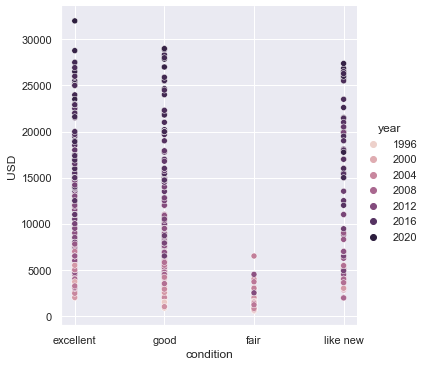

In [157]:
    fig = sns.relplot(data=outback[outback.condition != 'unknown'], x='condition', y='USD', hue='year')

In [206]:
outback.columns

Index(['USD', 'year', 'model', 'condition', 'cylinders', 'fuel', 'miles',
       'title_status', 'transmission', 'paint_color'],
      dtype='object')

<AxesSubplot:>

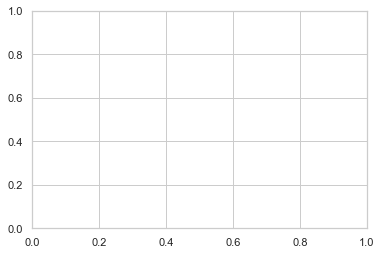

In [213]:
sns.scatterplot(data=outback, x='year', y='USD')

In [166]:
outback.groupby('year').mean()

,USD,miles
year,,
1996.0,1998.000000,159229.360000
1997.0,1658.333333,182333.333333
1998.0,2710.222222,204424.444444
1999.0,2476.545455,163762.593939
2000.0,2656.857143,182077.525714
2001.0,2703.200000,173087.198000
2002.0,2905.151515,183268.046620
2003.0,3139.735294,158916.289916
2004.0,3409.838710,158605.356631


<AxesSubplot:xlabel='miles', ylabel='USD'>

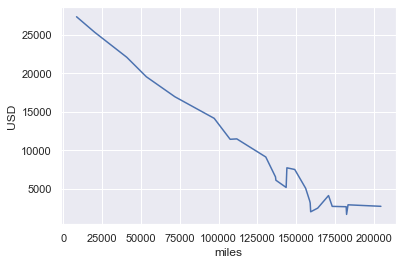

In [169]:
sns.lineplot(data=outback.groupby('year').mean(), x='miles', y='USD')

<AxesSubplot:xlabel='year', ylabel='USD'>

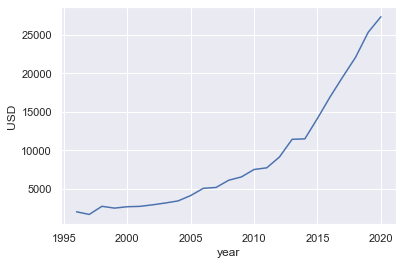

In [175]:
sns.lineplot(data=outback.groupby('year').mean(), x='year', y='USD')

<AxesSubplot:xlabel='condition', ylabel='USD'>

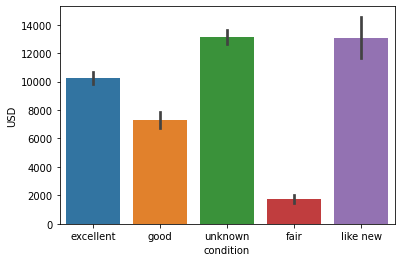

In [31]:
sns.barplot(x='condition', y='USD', data=outback)

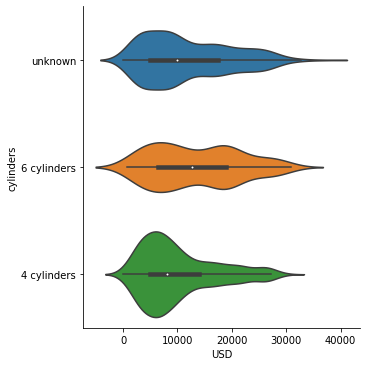

In [32]:
sns.catplot(y="cylinders", x="USD",kind = "violin", data=outback)

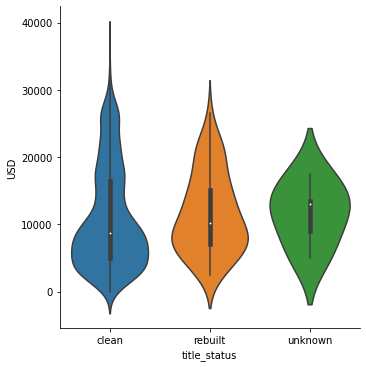

In [33]:
sns.catplot(x='title_status', y='USD', kind='violin', data=outback)

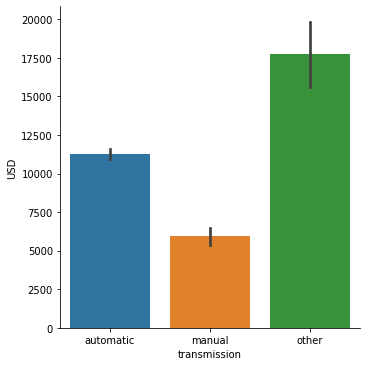

In [34]:
sns.catplot(x='transmission', y='USD', kind='bar', data=outback)

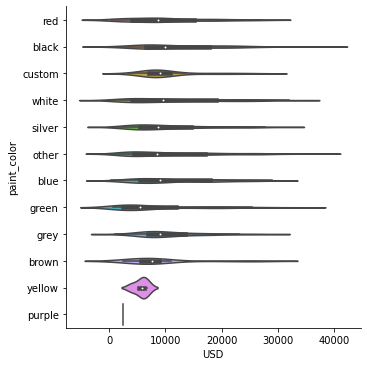

In [35]:
sns.catplot(y="paint_color", x="USD", kind="violin", data=outback)

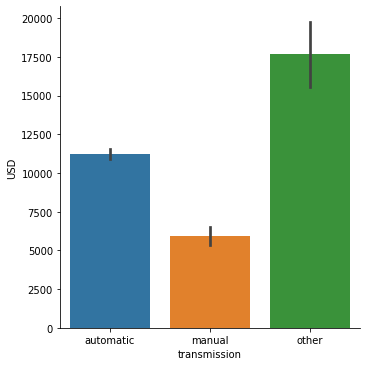

In [36]:
sns.catplot(x='transmission', y='USD', kind='bar', data=outback)

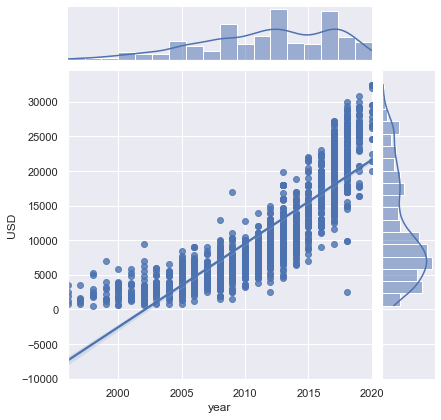

In [183]:
sns.jointplot(data=outback, x='year', y='USD', kind='reg', hue_norm='miles')

## Encoding categorical features

In [15]:
encoder = OrdinalEncoder()
ohe = OneHotEncoder(sparse=False)

In [16]:
ordinal_outback = outback[['condition', 'title_status']].copy()
categorical_outback = outback[['cylinders', 'fuel', 'transmission', 'paint_color']].copy()
numerical_outback = outback[['USD', 'year', 'miles']].copy()

In [17]:
ord_outback = pd.DataFrame(encoder.fit_transform(ordinal_outback), index=ordinal_outback.index, columns=ordinal_outback.columns)
cat_outback = pd.DataFrame(ohe.fit_transform(categorical_outback), index=categorical_outback.index, columns=ohe.get_feature_names())
clean_outback = pd.concat([numerical_outback, ord_outback, cat_outback], axis=1)

## Train/Test Split

In [19]:
y = clean_outback.USD
X = clean_outback.drop('USD', axis=1)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [21]:
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(1380, 27) (1380,)
(345, 27) (345,)


# Testing models

## Random Forest


In [22]:
regressor = RandomForestRegressor(n_estimators=20)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)


In [23]:
print('MAE:', round(MAE(y_test, y_pred), 2))
print('MSE:', round(MSE(y_test, y_pred), 2))
print('Score:', regressor.score(X_test, y_test)*100)

MAE: 1368.7
MSE: 6678187.95
Score: 89.67711464913147


In [24]:
outback

,USD,year,condition,cylinders,fuel,miles,title_status,transmission,paint_color
57,8498,2011.0,excellent,unknown,gas,138247.0,clean,automatic,red
520,8980,2006.0,good,6 cylinders,gas,98791.0,clean,automatic,custom
2099,15977,2015.0,unknown,unknown,gas,101802.0,clean,automatic,white
2965,8950,2013.0,unknown,4 cylinders,gas,116000.0,rebuilt,automatic,silver
3369,24395,2017.0,unknown,unknown,gas,39100.0,clean,automatic,other
...,...,...,...,...,...,...,...,...,...
457541,6995,2011.0,like new,4 cylinders,gas,144067.0,clean,automatic,blue
457611,27998,2018.0,unknown,unknown,gas,17019.0,clean,automatic,other
457739,22999,2017.0,unknown,unknown,gas,36939.0,clean,automatic,blue
457755,26480,2017.0,unknown,4 cylinders,gas,16845.0,clean,automatic,silver


## Making new predictions

In [25]:
new_data = [{'year': 2001,'condition': 'good', 'cylinders': '6 cylinders', 'fuel':'gas', 'miles': 200000.0, 'title_status':'clean', 'transmission':'automatic', 'paint_color':'black'}]
new_data = pd.DataFrame(new_data)

In [26]:
ordinal = ['condition', 'title_status'] # Ordinal Encoder
categorical = ['cylinders', 'fuel', 'transmission', 'paint_color'] # OHE
numerical = ['year', 'miles']

In [27]:
encoder.transform(new_data[ordinal])

array([[2., 0.]])

In [28]:
ord_ = pd.DataFrame(encoder.transform(new_data[ordinal]), index=new_data[ordinal].index, columns=new_data[ordinal].columns)
cat_ = pd.DataFrame(ohe.transform(new_data[categorical]), index=new_data[categorical].index, columns=ohe.get_feature_names())
clean_ = pd.concat([new_data[numerical], ord_, cat_], axis=1)

In [29]:
clean_

,year,miles,condition,title_status,x0_4 cylinders,x0_5 cylinders,x0_6 cylinders,x0_other,x0_unknown,x1_diesel,...,x3_brown,x3_custom,x3_green,x3_grey,x3_other,x3_purple,x3_red,x3_silver,x3_white,x3_yellow
0,2001,200000.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
regressor.predict(clean_)

array([2661.25])

## Same as above, but with a pipeline

In [67]:
ordinal = ['condition', 'title_status'] # Ordinal Encoder
categorical = ['cylinders', 'fuel', 'transmission', 'paint_color', 'model'] # OHE
numerical = ['year', 'miles']

In [68]:
y = outback.USD
X = outback.drop('USD', axis=1)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [70]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [71]:
ct = ColumnTransformer(transformers = [
                            ('ordinalEncoder', encoder, ordinal),
                            ('oneHotEncoder', ohe, categorical )
                            ],
                        remainder='passthrough')

In [36]:
X_train_transformed = ct.fit_transform(X_train)

In [37]:
regressor = RandomForestRegressor(n_estimators=20)
regressor.fit(X_train_transformed, y_train.values)
y_pred = regressor.predict(ct.transform(X_test))

In [38]:
print('MAE:', round(MAE(y_test, y_pred), 2))
print('MSE:', round(MSE(y_test, y_pred), 2))
print('Score:', regressor.score(ct.transform(X_test), y_test)*100)

MAE: 1166.72
MSE: 3342576.65
Score: 94.57931409732055


## Using Cross Val Score

In [39]:
cross_val_score(regressor, X_train_transformed, y_train.values, scoring='neg_mean_absolute_error', cv=3).mean()

-1338.975968537228

## Tuning with GridSearchCV

In [74]:
regressor = RandomForestRegressor(n_estimators=20)

In [75]:
pipe = Pipeline(steps=[('preprocess', ct),
                        ('model', regressor)])

In [79]:
parameters = {
  'model__n_estimators':list(range(5,110,5)),
  'model__criterion' : ['mae'],
  'model__max_features': ['auto', 'sqrt', 'log2'],
  'model__min_samples_split': [2,3,4,5]
  }

In [80]:
gs = GridSearchCV(estimator=pipe, param_grid=parameters, verbose=2)
 

In [81]:
gs.fit(X_train, y_train)

tal time=   0.5s
[CV] END model__criterion=mae, model__max_features=log2, model__min_samples_split=4, model__n_estimators=55; total time=   0.5s
[CV] END model__criterion=mae, model__max_features=log2, model__min_samples_split=4, model__n_estimators=60; total time=   0.5s
[CV] END model__criterion=mae, model__max_features=log2, model__min_samples_split=4, model__n_estimators=60; total time=   0.5s
[CV] END model__criterion=mae, model__max_features=log2, model__min_samples_split=4, model__n_estimators=60; total time=   0.5s
[CV] END model__criterion=mae, model__max_features=log2, model__min_samples_split=4, model__n_estimators=60; total time=   0.5s
[CV] END model__criterion=mae, model__max_features=log2, model__min_samples_split=4, model__n_estimators=60; total time=   0.5s
[CV] END model__criterion=mae, model__max_features=log2, model__min_samples_split=4, model__n_estimators=65; total time=   0.6s
[CV] END model__criterion=mae, model__max_features=log2, model__min_samples_split=4, mo

GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalEncoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['condition',
                                                                          'title_status']),
                                                                        ('oneHotEncoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                          

In [82]:
gs.best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalEncoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['condition',
                                                   'title_status']),
                                                 ('oneHotEncoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['cylinders', 'fuel',
                                                   'transmission',
                                                   'paint_color', 'model'])])),
                ('model',
                 RandomForestRegressor(crit

In [90]:
y_pred = gs.predict(X_test)
print('MAE:', round(MAE(y_test, y_pred), 2))
print('MSE:', round(MSE(y_test, y_pred), 2))

MAE: 1488.27
MSE: 5980452.72


In [88]:
import pickle

In [89]:
pickle.dump(gs.best_estimator_, open('modelV3.pkl', 'wb'))